In [98]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error


import matplotlib.pyplot as plt
import seaborn as sns

In [99]:
data_dir = os.getenv('HOME') + '/aiffel/AIFFEL_quest_cr/Exploration/EX02/data'
train_data_path = join(data_dir, 'train.csv')
test_data_path = join(data_dir, 'test.csv')

print(train_data_path)
print(test_data_path)

/aiffel/aiffel/AIFFEL_quest_cr/Exploration/EX02/data/train.csv
/aiffel/aiffel/AIFFEL_quest_cr/Exploration/EX02/data/test.csv


In [100]:
data = pd.read_csv(train_data_path)
sub = pd.read_csv(test_data_path)

print(f'train data dim : {data.shape}')
print(f'sub data dim : {sub.shape}')

train data dim : (15035, 21)
sub data dim : (6468, 20)


In [101]:
data.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [102]:
sub.head()

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,15035,20141209T000000,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
1,15036,20141209T000000,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
2,15037,20140512T000000,4,4.50,5420,101930,1.0,0,0,3,11,3890,1530,2001,0,98053,47.6561,-122.005,4760,101930
3,15038,20150415T000000,3,1.00,1780,7470,1.0,0,0,3,7,1050,730,1960,0,98146,47.5123,-122.337,1780,8113
4,15039,20150312T000000,3,2.50,1890,6560,2.0,0,0,3,7,1890,0,2003,0,98038,47.3684,-122.031,2390,7570


In [103]:
y = data['price']
del data['price']

In [104]:
## 결측 값 확인 
null_check = pd.isnull(data['id'])
print()

In [105]:
## 결측 값 개수
print('{} : {}'.format('id', len(data.loc[pd.isnull(data['id']), 'id'].values)))

id : 0


In [106]:
## Datetime 20141013T000000 형식의 데이터를 연/월 데이터만 사용하기 위해 201410까지 자르기 
data['date'] = data['date'].apply(lambda x : str(x[:6]))

data.head()

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,201410,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,201502,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,201502,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,201406,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,201501,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


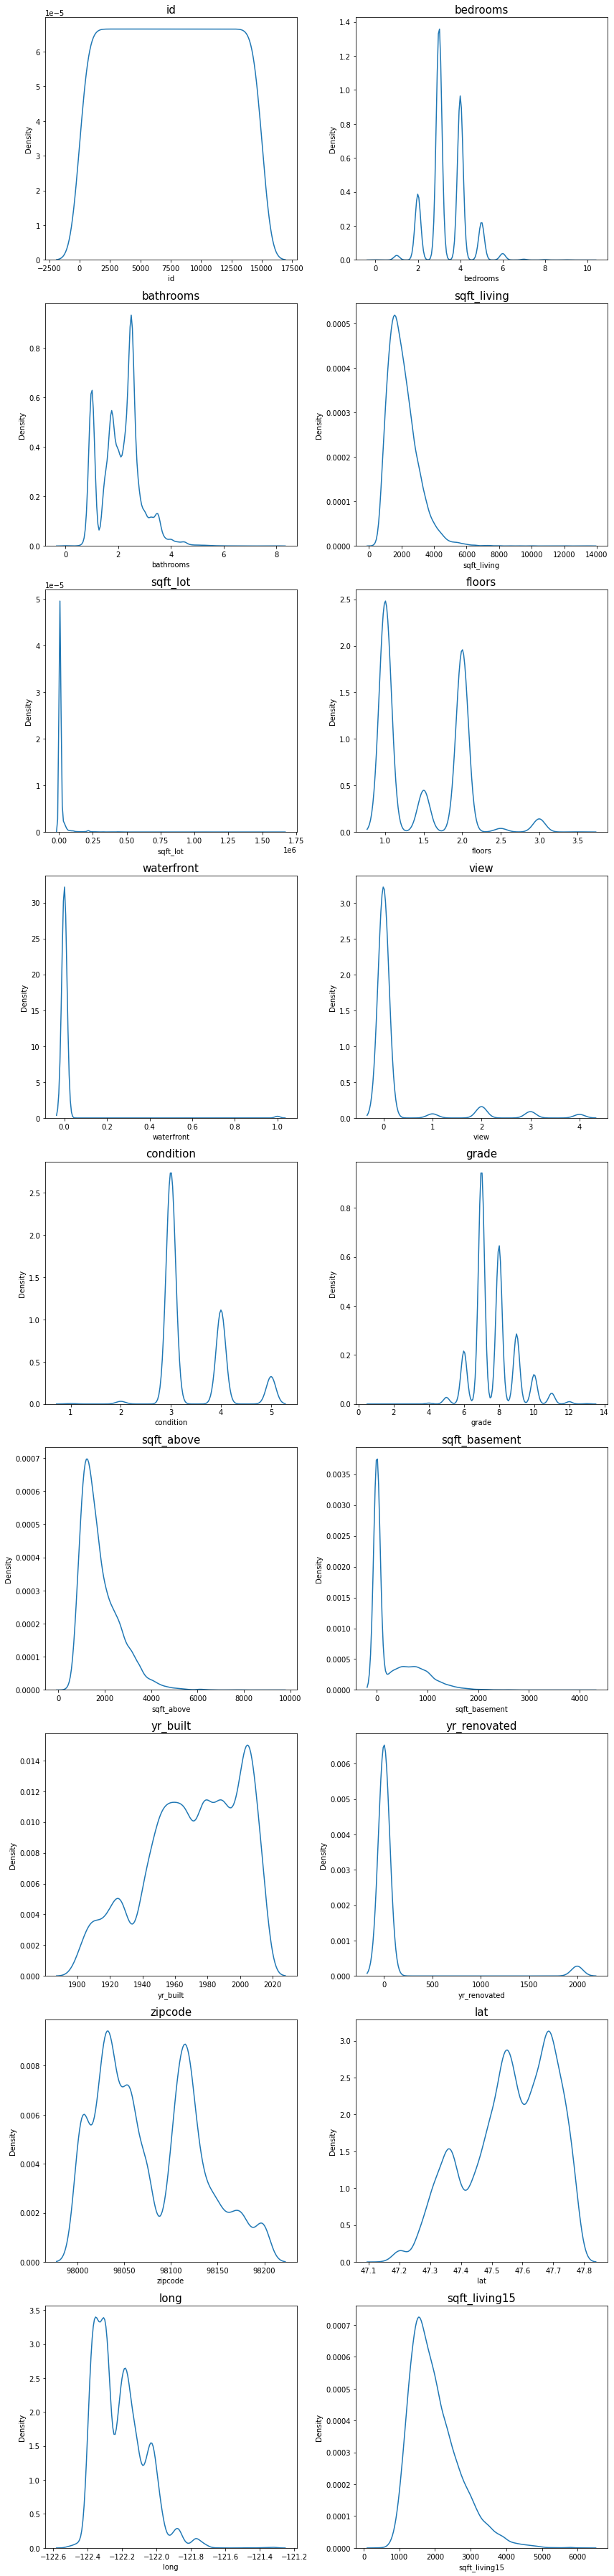

In [107]:
# Assuming `data` is your DataFrame
fig, ax = plt.subplots(9, 2, figsize=(12, 50))  # Adjust the figsize for better visibility

# Identify numeric columns (excluding the ID variable or any count==0 cases if necessary)
numeric_columns = data.select_dtypes(include=['number']).columns

# Plotting KDE for numeric columns
count = 0
for row in range(9):
    for col in range(2):
        if count < len(numeric_columns):  # Ensure that we don't exceed the number of numeric columns
            sns.kdeplot(data=data[numeric_columns[count]], ax=ax[row][col])
            ax[row][col].set_title(numeric_columns[count], fontsize=15)
            count += 1
        else:
            ax[row][col].set_visible(False)  # Hide unused subplots

plt.tight_layout()
plt.show()

In [108]:
## 한쪽으로 값이 쏠리는 feature들을 skew_columns list에 담아두기

skew_columns = ['bedrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_lot15', 'sqft_living15']

for c in skew_columns:
    ## log1p를 통해 value 값들을 정규분포 형태로 맞춤 
    data[c] = np.log1p(data[c].values)


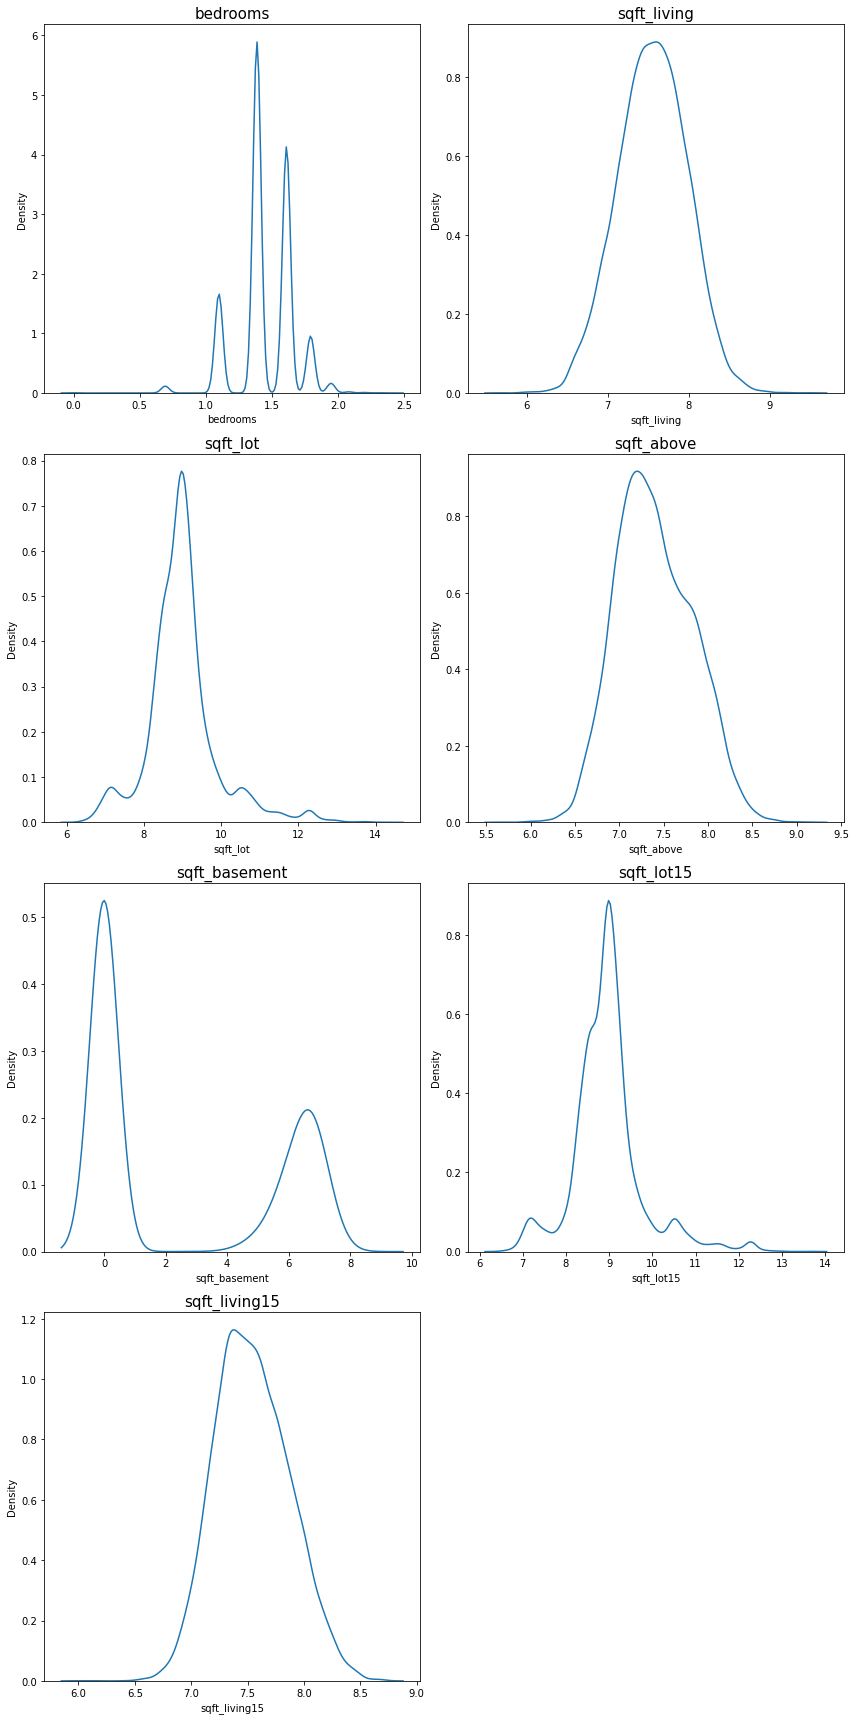

In [109]:
# Subplot configuration
num_plots = len(skew_columns)
nrows = (num_plots + 1) // 2  # Calculate the number of rows needed (2 plots per row)

fig, ax = plt.subplots(nrows, 2, figsize=(12, nrows * 6))  # Adjust figsize for better visibility

# Plotting KDE for log-transformed columns
count = 0
for row in range(nrows):
    for col in range(2):
        if count < len(skew_columns):  # Ensure that we don't exceed the number of log-transformed columns
            sns.kdeplot(data=data[skew_columns[count]], ax=ax[row][col])
            ax[row][col].set_title(skew_columns[count], fontsize=15)
            count += 1
        else:
            ax[row][col].set_visible(False)  # Hide unused subplots

plt.tight_layout()
plt.show()

##  Average Blending

In [110]:
gboost = GradientBoostingRegressor(random_state=2019)
xgboost = xgb.XGBRegressor(random_state=2019)
lightgbm = lgb.LGBMRegressor(random_state=2019)

models = [{'model':gboost, 'name':'GradientBoosting'}, {'model':xgboost, 'name':'XGBoost'},
          {'model':lightgbm, 'name':'LightGBM'}]

## Cross Validation

In [111]:
def get_cv_score(models):
    kfold = KFold(n_splits=5)
    for m in models:
        CV_score = np.mean(cross_val_score(m['model'], X=x.values, y=y, cv=kfold))
        print(f"Model: {m['name']}, CV score: {CV_score:.4f}")


## Make Submission File

In [112]:
def AveragingBlending(models, x, y, sub_x):
    for m in models : 
        m['model'].fit(x.values, y)
    
    predictions = np.column_stack([
        m['model'].predict(sub_x.values) for m in models
    ])
    return np.mean(predictions, axis=1)

## train data, test data를 integer 형태로 변환

In [113]:
data['date'] = data['date'].apply(lambda i: i[:6]).astype(int)
data.head()

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,201410,1.386294,1.00,7.074117,8.639588,1.0,0,0,3,7,7.074117,0.0,1955,0,98178,47.5112,-122.257,7.201171,8.639588
1,1,201502,1.098612,1.00,6.647688,9.210440,1.0,0,0,3,6,6.647688,0.0,1933,0,98028,47.7379,-122.233,7.908755,8.995041
2,2,201502,1.386294,2.00,7.427144,8.997271,1.0,0,0,3,8,7.427144,0.0,1987,0,98074,47.6168,-122.045,7.496097,8.923191
3,3,201406,1.386294,2.25,7.447751,8.827615,2.0,0,0,3,7,7.447751,0.0,1995,0,98003,47.3097,-122.327,7.713785,8.827615
4,4,201501,1.386294,1.50,6.966967,9.181118,1.0,0,0,3,7,6.966967,0.0,1963,0,98198,47.4095,-122.315,7.409136,9.181118


In [114]:
y.astype(int)

0         221900
1         180000
2         510000
3         257500
4         291850
          ...   
15030     610685
15031    1007500
15032     360000
15033     400000
15034     325000
Name: price, Length: 15035, dtype: int64

In [115]:
random_state = 100 ## model의 성능을 비교하기 위해서 random_state = 100으로 고정
gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

models = [gboost, xgboost, lightgbm, rdforest]


In [116]:
def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(y_test, y_pred))

In [117]:
## 오류 메세지 ->  Input contains NaN, infinity or a value too large for dtype('float64'). -> RMSE, exp1 계산에서 Nan 값이나 Inf 값을 처리해서오류

def get_scores(models, train, y):
    df = {}

    for model in models:
        model_name = model.__class__.__name__
        
        X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        # NaN 및 Inf 값 처리
        if np.any(np.isnan(y_pred)) or np.any(np.isinf(y_pred)):
            y_pred = np.nan_to_num(y_pred, nan=0, posinf=0, neginf=0)
        
        df[model_name] = rmse(y_test, y_pred)
    
    score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
    return score_df


In [118]:
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [1, 10],
}


In [119]:
model = LGBMRegressor(random_state=random_state)

In [120]:
def my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5):
    # GridSearchCV 모델로 초기화
    grid_model = GridSearchCV(model, param_grid=param_grid, scoring='neg_mean_squared_error', 
                              cv=5, verbose=verbose, n_jobs=n_jobs)
    
    # 모델 fitting
    grid_model.fit(train, y) 

    # 결과값 저장
    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']
    
    # 데이터 프레임 생성
    results = pd.DataFrame(params)
    results['score'] = score
    
    # RMSLE 값 계산 후 정렬
    results['RMSLE'] = np.sqrt(-1 * results['score'])
    results = results.sort_values('RMSLE')

    return results


In [121]:
test

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,15035,20141209T000000,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
1,15036,20141209T000000,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
2,15037,20140512T000000,4,4.50,5420,101930,1.0,0,0,3,11,3890,1530,2001,0,98053,47.6561,-122.005,4760,101930
3,15038,20150415T000000,3,1.00,1780,7470,1.0,0,0,3,7,1050,730,1960,0,98146,47.5123,-122.337,1780,8113
4,15039,20150312T000000,3,2.50,1890,6560,2.0,0,0,3,7,1890,0,2003,0,98038,47.3684,-122.031,2390,7570
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6463,21498,20140626T000000,3,1.75,1500,11968,1.0,0,0,3,6,1500,0,2014,0,98010,47.3095,-122.002,1320,11303
6464,21499,20150126T000000,3,2.00,1490,1126,3.0,0,0,3,8,1490,0,2014,0,98144,47.5699,-122.288,1400,1230
6465,21500,20150219T000000,3,2.50,1310,1294,2.0,0,0,3,8,1180,130,2008,0,98116,47.5773,-122.409,1330,1265
6466,21501,20140623T000000,2,0.75,1020,1350,2.0,0,0,3,7,1020,0,2009,0,98144,47.5944,-122.299,1020,2007


In [122]:
data

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,201410,1.386294,1.00,7.074117,8.639588,1.0,0,0,3,7,7.074117,0.000000,1955,0,98178,47.5112,-122.257,7.201171,8.639588
1,1,201502,1.098612,1.00,6.647688,9.210440,1.0,0,0,3,6,6.647688,0.000000,1933,0,98028,47.7379,-122.233,7.908755,8.995041
2,2,201502,1.386294,2.00,7.427144,8.997271,1.0,0,0,3,8,7.427144,0.000000,1987,0,98074,47.6168,-122.045,7.496097,8.923191
3,3,201406,1.386294,2.25,7.447751,8.827615,2.0,0,0,3,7,7.447751,0.000000,1995,0,98003,47.3097,-122.327,7.713785,8.827615
4,4,201501,1.386294,1.50,6.966967,9.181118,1.0,0,0,3,7,6.966967,0.000000,1963,0,98198,47.4095,-122.315,7.409136,9.181118
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15030,15030,201410,1.609438,2.50,7.832411,8.703507,2.0,0,0,3,9,7.832411,0.000000,2014,0,98056,47.5137,-122.167,7.832411,8.703507
15031,15031,201503,1.609438,3.50,8.163656,8.881975,2.0,0,0,3,9,7.863651,6.814543,2009,0,98136,47.5537,-122.398,7.626083,8.732466
15032,15032,201405,1.386294,2.50,7.333676,7.031741,3.0,0,0,3,8,7.333676,0.000000,2009,0,98103,47.6993,-122.346,7.333676,7.319865
15033,15033,201502,1.609438,2.50,7.745436,8.668024,2.0,0,0,3,8,7.745436,0.000000,2014,0,98146,47.5107,-122.362,7.512618,8.881975


In [123]:
## model.predict에서 test['date'] 형식이 다름 
X_train

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
8507,8507,201410,1.386294,2.00,7.300473,7.825245,2.0,0,0,3,7,7.300473,0.000000,1991,0,98103,47.6969,-122.338,7.523481,8.517393
9123,9123,201502,1.386294,1.75,7.147559,8.902592,1.0,0,0,4,7,7.147559,0.000000,1967,0,98005,47.6046,-122.168,7.539559,8.902592
4715,4715,201409,1.386294,1.00,6.846943,9.036106,1.0,0,0,5,7,6.846943,0.000000,1958,0,98056,47.5112,-122.167,6.857514,9.036106
3959,3959,201407,1.386294,2.50,7.606387,8.341887,2.0,0,0,3,8,7.606387,0.000000,1998,0,98034,47.7320,-122.197,7.606387,8.662159
2203,2203,201504,1.945910,2.00,7.783641,8.947026,1.0,0,0,3,6,7.090910,7.090910,1932,2005,98028,47.7705,-122.269,7.163172,9.190240
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12119,12119,201412,1.945910,3.00,7.812378,9.140883,2.0,0,0,3,8,7.812378,0.000000,1982,0,98007,47.6025,-122.153,7.812378,9.154299
8039,8039,201408,1.098612,1.00,6.928538,8.517393,1.0,0,0,4,7,6.928538,0.000000,1916,0,98117,47.6781,-122.363,7.300473,8.517393
14147,14147,201405,1.098612,1.50,7.057037,7.271704,2.0,0,0,3,7,7.057037,0.000000,2001,0,98144,47.5917,-122.295,7.107425,7.462215
6936,6936,201502,1.386294,2.75,7.820440,8.188967,2.0,0,0,3,8,7.736744,5.303305,1906,0,98122,47.6098,-122.292,7.539559,8.188967


In [124]:
model = LGBMRegressor(max_depth=10, n_estimators=100, random_state=random_state)
model.fit(X_train, y_train)
prediction = model.predict(X_test)
prediction

array([249060.62462667, 429888.02914384, 417721.67115336, ...,
       617480.72418163, 292376.35942133, 376229.562291  ])

In [125]:
def save_submission(model, train, y, test, model_name, rmsle=None):
    model.fit(train, y)
    prediction = model.predict(test)
    prediction = np.expm1(prediction)  # 로그 변환을 원래 스케일로 되돌리기

    data_dir = os.path.expanduser('~/aiffel/AIFFEL_quest_cr/Exploration/EX02/data')
    submission_path = join(data_dir, 'sample_submission.csv')
    submission = pd.read_csv(submission_path)

    # 'price' 컬럼에 예측 결과 저장
    submission['price'] = prediction

    # 숫자형 데이터만 남기고 나머지 컬럼 제거
    numeric_submission = submission.select_dtypes(include=[np.number])

    # 제출 파일 저장
    submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, model_name, rmsle)
    numeric_submission.to_csv(submission_csv_path, index=False)
    print('{} 저장 완료!'.format(submission_csv_path))


In [128]:
# 'date' 컬럼 제거 (예측에 필요 없는 컬럼)
data = data.drop(['date'], axis=1, errors='ignore')  # 'date' 컬럼이 없을 수도 있기 때문에 errors='ignore' 사용
test = test.drop(['date'], axis=1, errors='ignore')  # 동일하게 'date' 컬럼 제거

In [129]:
# 함수 호출
save_submission(model, data, y, test, 'lgbm', rmsle='0.164399')

/aiffel/aiffel/AIFFEL_quest_cr/Exploration/EX02/data/submission_lgbm_RMSLE_0.164399.csv 저장 완료!
